In [1]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt
import json

from src.model import MockModel
from src.utils import index_for_arange, write_results, cq_filter, cq_labels
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [2]:
# load data
dataset = 'atis'
intent_classifier = 'bert'
data_dir = f'data/{dataset}/{intent_classifier}/'

df_train_preds = pd.read_csv(data_dir + "train_predictions.csv")
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv")
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv")

labels = pd.read_csv(data_dir+'/labels.csv', header=0, names=['index','label'])
labels = list(labels.label)
N_INTENTS = len(labels)
N_INTENTS

26

In [3]:
# check train-calibration-test split sizes
df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]

(3522, 1175, 1174)

In [4]:
# apply some basic transformations
df_train = df_train_preds.reset_index().rename(columns={'index': 'utterance'})
df_test = df_test_preds.reset_index().rename(columns={'index': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'index': 'utterance'})

df_train['utterance'] = df_train['utterance'].apply(lambda h: 'train_' + str(h))
df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))

df_train['utterance'] = df_train['utterance'].astype(str)
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)

In [5]:
# merge datasets to single frame
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'hash', 'text'], axis=1)
fullset.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_16,label_17,label_18,label_19,label_20,label_21,label_22,label_23,label_24,label_25
0,test_0,0.005376,0.020964,0.008766,0.001087,0.010478,0.004582,0.003384,0.009285,0.770127,...,0.007280,0.007319,0.010551,0.006741,0.016093,0.029515,0.012482,0.012054,0.002456,0.008578
1,test_1,0.000051,0.000076,0.000036,0.000105,0.000040,0.000039,0.000062,0.000067,0.000054,...,0.000069,0.000047,0.000049,0.000126,0.000022,0.000237,0.000043,0.000061,0.000026,0.000058
2,test_2,0.000046,0.000089,0.000035,0.000075,0.000039,0.000036,0.000063,0.000063,0.000055,...,0.000068,0.000048,0.000048,0.000122,0.000021,0.000163,0.000041,0.000065,0.000029,0.000055
3,test_3,0.000042,0.000078,0.000033,0.000078,0.000040,0.000034,0.000057,0.000060,0.000053,...,0.000067,0.000047,0.000046,0.000112,0.000020,0.000154,0.000039,0.000065,0.000027,0.000053
4,test_4,0.000043,0.000083,0.000034,0.000078,0.000041,0.000035,0.000053,0.000061,0.000054,...,0.000067,0.000048,0.000047,0.000122,0.000021,0.000156,0.000039,0.000064,0.000027,0.000054


In [6]:
# parameters for evaluation
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .01
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [7]:
# instantiate a mock sklearn model which simply looks up the results in a lookup table
model = MockModel(fullset, 'utterance', softmax=False, classes=range(N_INTENTS))
# fit the test dataset
model.fit(X_test, df_test['label'])
# extract the test targets from the datasets
y_test = df_test['label'].apply(lambda lbl: list(model.classes_).index(lbl))

In [8]:
# marginal conformal prediction
mapie_marginal = MapieClassifier(estimator=model, cv="prefit", method="score", random_state=42)
mapie_marginal.fit(X_calib, df_calibration['label'])
y_pred_marginal, y_ps_marginal = mapie_marginal.predict(X_test, alpha=alpha)


coverages_marginal = [
    classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_marginal = [
    adjusted_classification_x_width_score(y_ps_marginal[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_marginal = [
    set_size_equals(y_ps_marginal[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_marginal = [
    (y_ps_marginal[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_marginal = [
    size_stratified_classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]

results = cq_stats(y_ps_marginal[:, :, target_index], y_test, max_ps_size)

write_results('atis-bert-cicc', dataset, intent_classifier, 'cicc', results)
results

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 26 unique labels while calibration have 17 unique labels
  warnings.warn(
/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.985519591141397, 0.9761499148211243, 2.5357142857142856, 0.0)

In [9]:
# adaptive conformal prediction
mapie_adaptive = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score", random_state=42)
mapie_adaptive.fit(X_calib, df_calibration['label'])
y_pred_adaptive, y_ps_adaptive = mapie_adaptive.predict(X_test, alpha=alpha)


coverages_adaptive = [
    classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_adaptive = [
    adjusted_classification_x_width_score(y_ps_adaptive[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_adaptive = [
    set_size_equals(y_ps_adaptive[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_adaptive = [
    (y_ps_adaptive[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_adaptive = [
    size_stratified_classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_adaptive[:, :, target_index], y_test, max_ps_size)

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 26 unique labels while calibration have 17 unique labels
  warnings.warn(


(0.996135265700483, 0.7776831345826235, 4.073770491803279, 0.12350936967632027)

In [10]:
# TOP-K conformal prediction
mapie_topk = MapieClassifier(estimator=model, cv="prefit", method="top_k", random_state=42)
mapie_topk.fit(X_calib, df_calibration['label'])
y_pred_topk, y_ps_topk = mapie_topk.predict(X_test, alpha=alpha)


coverages_topk = [
    classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_topk = [
    adjusted_classification_x_width_score(y_ps_topk[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_topk = [
    set_size_equals(y_ps_topk[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_topk = [
    (y_ps_topk[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_topk = [
    size_stratified_classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_topk[:, :, target_index], y_test, max_ps_size)

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 26 unique labels while calibration have 17 unique labels
  warnings.warn(
/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9872231686541738, 0.0, 2.0, 0.0)

In [11]:
# RAPS
mapie_raps = MapieClassifier(estimator=model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)


coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_raps = [
    set_size_equals(y_ps_raps[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_raps = [
    (y_ps_raps[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_raps[:, :, target_index], y_test, max_ps_size)

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 26 unique labels while calibration have 17 unique labels
  warnings.warn(


(0.9958115183246073, 0.6942078364565588, 3.807142857142857, 0.217206132879046)

In [12]:
# heuristic 1: select all classes above a certain cutoff or the top-5 if there are none
topk_cutoff = TopKCutoffSelector(estimator=model, cutoff=1-target_alpha, k=5)
y_ps_h1 = topk_cutoff.predict(X_test)
results = cq_stats(y_ps_h1, y_test, max_ps_size)
write_results('atis-bert-h1', dataset, intent_classifier, 'h1', results)
results

(0.9948892674616695, 0.7308347529812607, 5.0, 0.0)

In [13]:
top_95 = HeuristicCutoffSelector(estimator=model, cutoff=1-target_alpha)
y_ps_h2 = top_95.predict(X_test)
results = cq_stats(y_ps_h2, y_test, max_ps_size)
write_results('atis-bert-h2', dataset, intent_classifier, 'h2', results)
results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9787052810902896, 1.0, nan, 0.0)

In [14]:
topk_5 = TopKSelector(estimator=model, k=5)
y_ps_h3 = topk_5.predict(X_test)

results = cq_stats(y_ps_h3, y_test, max_ps_size)
write_results('atis-bert-h3', dataset, intent_classifier, 'h3', results)
results

(0.9965928449744463, 0.0, 5.0, 0.0)

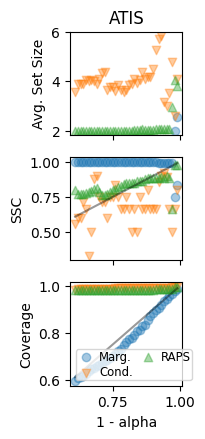

In [21]:
plot.plot_coverages_widths_multi(
        alpha,
        [
            coverages_marginal,
            coverages_adaptive,
            coverages_raps,
            ],
        [
            cqsize_marginal,
            cqsize_adaptive,
            cqsize_raps
            ],
        ['Marg.', 'Cond.', 'RAPS'],
        legend=(2, 'lower left'),
        sscs=[
            ssc_marginal,
            ssc_adaptive,
            ssc_raps,
        ],
        # hlines=(
        #     (results_h1[0], ssc_top_5_95, coverages_top_5_95,  'H1', 'dashed'),
        #     (widths_mean_top_95, ssc_top_95, coverages_top_95,  'H2', 'dotted'),
        #     (widths_mean_topk_5, ssc_topk_5, coverages_topk_5,  'H3', '-.'),
        # ),
        plot_ssc=True,
        markers=('o', 'v', '^',),
        dataset=dataset,
        model=intent_classifier,
        title="ATIS"
)

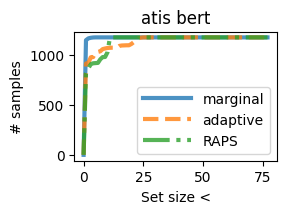

In [15]:
to_plot = [
    (y_ps_marginal, 'marginal', '-', None),
    (y_ps_adaptive, 'adaptive', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title(f'{dataset} {intent_classifier}'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig(f'results/cum_set_size_{dataset}_{intent_classifier}.png', dpi=1200)

In [16]:
y_ps_which = y_ps_marginal
ambiguous_indices = np.where((y_ps_which[:, :, target_index].sum(axis=1) >= 2))
ambiguous = df_test.loc[ambiguous_indices]
list(zip(ambiguous.index,[ labels[l] for l in ambiguous.label.tolist()], ambiguous.text.tolist()))

[(19,
  'flight_no',
  'what is the flight number for the continental flight which leaves denver at 1220 pm and goes to san francisco'),
 (31, 'city', 'what time zone is denver in'),
 (39, 'city', 'where is lester pearson airport'),
 (84, 'flight_no', 'flight number from dallas to houston'),
 (99,
  'ground_fare',
  'how much is the ground transportation between atlanta and downtown'),
 (107,
  'flight_time',
  'what is the minimum connection time for houston intercontinental'),
 (276, 'flight', 'us 201'),
 (279, 'city', 'where is general mitchell international located'),
 (319, 'airport', 'please list information regarding san francisco airport'),
 (424,
  'aircraft',
  "i need a plane that arrives in san francisco by 9 o'clock pm on friday and leaves from baltimore"),
 (501,
  'ground_service',
  'how long does the ground transportation take from the salt lake city airport'),
 (549,
  'meal',
  'what meals are served on american flight 665 673 from milwaukee to seattle'),
 (553, 'air

In [17]:
for a in ambiguous.index:
    alternatives = np.where(y_ps_which[a, :, target_index])[0]
    print(" & ".join([ambiguous.loc[a].text, labels[ambiguous.loc[a].label].replace("_", " "), ', '.join([labels[l].replace("_", " ") for l in alternatives])]) + " \\\\")

what is the flight number for the continental flight which leaves denver at 1220 pm and goes to san francisco & flight no & capacity, flight no, flight time, quantity \\
what time zone is denver in & city & city, distance, flight time \\
where is lester pearson airport & city & airport, city \\
flight number from dallas to houston & flight no & capacity, flight+airfare, flight no, flight time, quantity \\
how much is the ground transportation between atlanta and downtown & ground fare & ground fare, ground service \\
what is the minimum connection time for houston intercontinental & flight time & distance, flight time, ground fare, ground service \\
us 201 & flight & abbreviation, distance, ground service \\
where is general mitchell international located & city & airport, city \\
please list information regarding san francisco airport & airport & airport, city, ground service \\
i need a plane that arrives in san francisco by 9 o'clock pm on friday and leaves from baltimore & aircraft

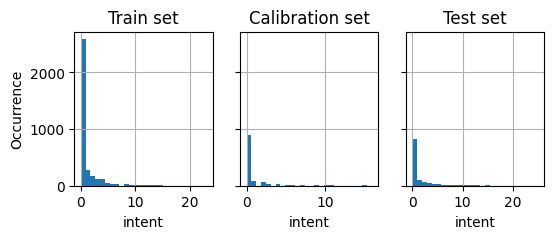

In [18]:
label_sorting_map = {i: x for x, i in enumerate(df_train.label.value_counts(sort=True).index)}
for i in range(len(labels)):
    if i not in label_sorting_map:
        label_sorting_map[i] = len(label_sorting_map)
fig, axs = plt.subplots(1,3,figsize=(plot.fig_width_in * 2, 2), sharey=True)
pd.Series(list(map(lambda x: label_sorting_map[x], df_train.label, ))).hist(bins=N_INTENTS, ax=axs[0])
pd.Series(list(map(lambda x: label_sorting_map[x], df_calibration.label, ))).hist(bins=N_INTENTS, ax=axs[1])
pd.Series(list(map(lambda x: label_sorting_map[x], df_test.label, ))).hist(bins=N_INTENTS, ax=axs[2])
titles = ['Train set', 'Calibration set', 'Test set']
[ax.set_xlabel('intent') for ax in axs]
[ax.set_title(title) for (ax, title) in zip(axs, titles)]
axs[0].set_ylabel('Occurrence')
# plt.yticks([]) 
plt.savefig(f"results/label_distribution_{dataset}.png", dpi=1200)
plt.show()

In [19]:
cq_inputs = df_test[cq_filter(y_ps_marginal[:, :, target_index], max_ps_size)].text
cq_lbls = cq_labels(y_ps_marginal[:, :, target_index], max_ps_size, labels)

cqs = []
for i, (text, lbls) in enumerate(zip(cq_inputs, cq_lbls)):
    cqs.append({
        "id": i,
        "text": text,
        "predictions": lbls,
    })

with open(f'results/clarification_questions_{dataset}_{intent_classifier}.json', 'w') as f:
    json.dump(cqs, f, indent=4)

In [20]:
pd.Series(np.cumsum([set_size_equals(y_ps_marginal[:, :, target_index], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}.csv')